In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from vit_tensorflow.ViT import ViT
from einops import repeat


# Enable eager execution
tf.config.experimental_run_functions_eagerly(True)

import matplotlib.pyplot as plt
import numpy as np
import os
import random

from PIL import Image
from pathlib import Path
from datasets import load_dataset



In [28]:
import vit_tensorflow.ViT
print(dir(vit_tensorflow.ViT))


['Attention', 'Layer', 'MLP', 'Model', 'PreNorm', 'Rearrange', 'Sequential', 'Transformer', 'ViT', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'einsum', 'nn', 'pair', 'rearrange', 'repeat', 'tf']


In [29]:
# Load your data
data_dir = 'C:\\Users\\franc\\Documents\\GitHub\\Car_Detection_Chat\\testando'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=64
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=64
)


Found 6553 files belonging to 66 classes.
Using 5243 files for training.
Found 6553 files belonging to 66 classes.
Using 1310 files for validation.


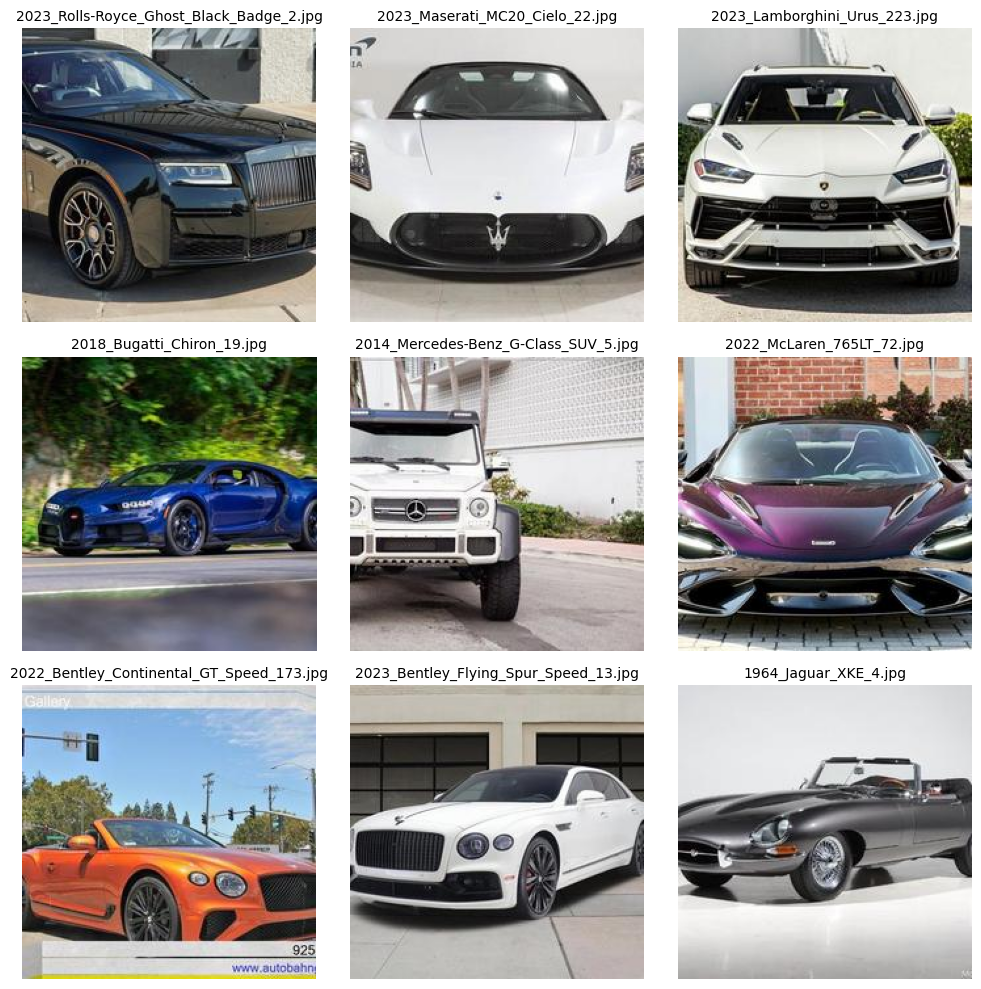

In [30]:
data_dir_object = Path('C:\\Users\\franc\\Documents\\GitHub\\Car_Detection_Chat\\testando')  


# Fetch all images from the dataset
all_images = list(data_dir_object.glob('**/*.jpg'))  # assuming all images are jpg. You can adjust the pattern accordingly.

# Sample 9 random images
random_images = random.sample(all_images, 9)

# Display the images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for ax, img_path in zip(axes.ravel(), random_images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_path.name, fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:

# # Verify problems wtht the files

# for root, dirs, files in os.walk(data_dir):
#     for file in files:
#         if file.lower().endswith(('.png', '.jpg', '.jpeg')):
#             file_path = os.path.join(root, file)
#             try:
#                 with Image.open(file_path) as img:
#                     img.verify()
#             except Exception as e:
#                 print(f"Problem with file: {file_path}. Error: {e}")


In [ ]:
# # CHECK ENCODING
# def check_utf8_encoding(data_dir):
#     for root, dirs, files in os.walk(data_dir):
#         # # Check directory names
#         # for dir_name in dirs:
#         #     try:
#         #         dir_name.decode('utf-8')
#         #     except UnicodeDecodeError:
#         #         print(f"Non-UTF-8 directory name detected: {os.path.join(root, dir_name)}")
        
#         # Check file names
#         for file_name in files:
#             try:
#                 file_name.encode('utf-8').decode('utf-8')
#             except UnicodeDecodeError:
#                 print(f"Non-UTF-8 file name detected: {os.path.join(root, file_name)}")

# data_dir = 'C:\\Users\\franc\\Documents\\GitHub\\Car_Detection_Chat\\images_backup'
# check_utf8_encoding(data_dir)

In [31]:
def normalize_image(img, label):
    img = img / 255.0
    return img, label

train_ds = train_ds.map(normalize_image)
val_ds = val_ds.map(normalize_image)


In [32]:
sample_img, sample_label = next(iter(train_ds.take(1)))
print("Min Value:", tf.reduce_min(sample_img).numpy())
print("Max Value:", tf.reduce_max(sample_img).numpy())


Min Value: 0.0
Max Value: 1.0


In [ ]:
# Old code. Not to be used.
# # Load the pre-trained ViT model and feature extractor
# extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
# model = TFAutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")


In [33]:
# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.3),  # Rotates the image up to a fraction of 0.1 of 360 degrees
    layers.experimental.preprocessing.RandomZoom(0.2),      # Randomly zooms the image up to 20%
    layers.experimental.preprocessing.RandomTranslation(0.3, 0.3),  # Randomly translates the image up to 10% horizontally and vertically
    # Add more augmentation layers if needed
])


In [34]:
@tf.function

def prepare_data(images, labels, training=True):
    # Apply augmentation only if it's training
    if training:
        images = data_augmentation(images, training=True)

    # Clip values to ensure they're between 0 and 1
    images = tf.clip_by_value(images, 0, 1)
    
    return images, labels

In [35]:
train_ds = train_ds.map(lambda x, y: tf.py_function(prepare_data, [x, y], [tf.float32, tf.int32]))
val_ds = val_ds.map(lambda x, y: tf.py_function(prepare_data, [x, y], [tf.float32, tf.int32]))

In [48]:
class ModifiedViT(ViT):
    def call(self, img, training=True, **kwargs):
        x = self.patch_embedding(img)
        b, n, d = x.shape

        cls_tokens = tf.repeat(self.cls_token, repeats=tf.shape(img)[0], axis=0)
        cls_tokens = tf.reshape(cls_tokens, [-1, 1, self.dim])  # Reshape to [batch_size, 1, dim]


        x = tf.concat([cls_tokens, x], axis=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x, training=training)

        x = self.transformer(x, training=training)

        if self.pool == 'mean':
            x = tf.reduce_mean(x, axis=1)
        else:
            x = x[:, 0]

        return x  # return features here before applying the classification head


In [49]:
# Create an instance of ModifiedViT and freeze all its layers
vit_model = ModifiedViT(
    image_size=224,
    patch_size=16,
    num_classes=1000,   # This won't be used in ModifiedViT, but it's a required parameter.
    dim=768,
    depth=12,
    heads=12,
    mlp_dim=3072,
    dropout=0.1,
    emb_dropout=0.1
)
for layer in vit_model.layers:
    layer.trainable = False

In [ ]:
vit_model = ModifiedViT(
    image_size=224,
    patch_size=16,
    num_classes=1000,   # This won't be used in ModifiedViT, but it's a required parameter.
    dim=768,
    depth=12,
    heads=12,
    mlp_dim=3072,
    dropout=0.1,
    emb_dropout=0.1
)


# 1. Get a sample image batch
sample_images, _ = next(iter(train_ds))

# 2. Modify the ModifiedViT call method to print the required values just before the line causing the error
def debug_call(self, img, training=True, **kwargs):
    x = self.patch_embedding(img)
    b, n, d = x.shape
    print("Shape of self.cls_token:", self.cls_token.shape)
    print("Values of b, n, d:", b, n, d)
    cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
    # ... rest of the method ...

# Temporarily replace the call method for debugging
original_call = ModifiedViT.call
ModifiedViT.call = debug_call

# 3. Pass the sample image through the modified vit_model
_ = vit_model(sample_images)

# Restore the original call method
ModifiedViT.call = original_call

In [50]:
# Attach a new classifier to the output of vit_model
num_classes = 66
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))

In [53]:
temp_instance = ModifiedViT(
    image_size=224,
    patch_size=16,
    num_classes=1000,
    dim=1024,
    depth=6,
    heads=16,
    mlp_dim=2048,
    dropout=0.1,
    emb_dropout=0.1
)

print(dir(temp_instance))


['_SCALAR_UPRANKING_ON', '_TF_MODULE_IGNORED_PROPERTIES', '__call__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_activity_regularizer', '_add_trackable', '_add_trackable_child', '_add_variable_with_custom_getter', '_aggregate_exact_metrics', '_assert_compile_was_called', '_assert_weights_created', '_auto_config', '_auto_get_config', '_auto_track_sub_layers', '_autocast', '_autographed_call', '_base_model_initialized', '_build_input_shape', '_call_spec', '_callable_losses', '_captured_weight_regularizer', '_cast_single_input', '_check_call_args', '_check_sample_weight_warning', '_checkpoint', '_checkpoint_dependencies', '_clear_lo

In [52]:
features = vit_model(input_layer)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(features)


AttributeError: Exception encountered when calling layer "modified_vi_t_8" (type ModifiedViT).

in user code:

    File "C:\Users\franc\AppData\Local\Temp\ipykernel_15864\2764568632.py", line 7, in call  *
        cls_tokens = tf.reshape(cls_tokens, [-1, 1, self.dim])  # Reshape to [batch_size, 1, dim]

    AttributeError: 'ModifiedViT' object has no attribute 'dim'


Call arguments received by layer "modified_vi_t_8" (type ModifiedViT):
  • img=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • training=True
  • kwargs=<class 'inspect._empty'>

In [ ]:
# Compile and prepare for training
fine_tuned_model = tf.keras.models.Model(inputs=input_layer, outputs=output)
fine_tuned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])